# Swiss Alps

In [ ]:
# Importing packages 
import rasterio
from rasterio.merge import merge
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches

In [2]:
# Band 3 (Green)
Sb3_files = [
    r"C:\Users\ameli\OneDrive\Swiss_028_0915\LC09_L2SP_195028_20240915_20240916_02_T1_SR_B3.TIF",
    r"C:\Users\ameli\OneDrive\swiss_109529_0915\LC09_L2SP_195029_20240915_20240916_02_T1_SR_B3.TIF"]
Sb3_srcs = [rasterio.open(fp) for fp in Sb3_files]
Sb3_mosaic, Sb3_transform = merge(Sb3_srcs)

# Band 5 (NIR)
Sb5_files = [
    r"C:\Users\ameli\OneDrive\Swiss_028_0915\LC09_L2SP_195028_20240915_20240916_02_T1_SR_B5.TIF",
    r"C:\Users\ameli\OneDrive\swiss_109529_0915\LC09_L2SP_195029_20240915_20240916_02_T1_SR_B5.TIF"]
Sb5_srcs = [rasterio.open(fp) for fp in Sb5_files]
Sb5_mosaic, Sb5_transform = merge(Sb5_srcs)

# Band 6 (SWIR)
Sb6_files = [r"C:\Users\ameli\OneDrive\Swiss_028_0915\LC09_L2SP_195028_20240915_20240916_02_T1_SR_B6.TIF",
             r"C:\Users\ameli\OneDrive\swiss_109529_0915\LC09_L2SP_195029_20240915_20240916_02_T1_SR_B6.TIF"]
Sb6_srcs = [rasterio.open(fp) for fp in Sb6_files]
Sb6_mosaic, Sb6_transform = merge(Sb6_srcs)

# Band 7 (SWIR2)
Sb7_files = [r"C:\Users\ameli\OneDrive\Swiss_028_0915\LC09_L2SP_195028_20240915_20240916_02_T1_SR_B7.TIF",
             r"C:\Users\ameli\OneDrive\swiss_109529_0915\LC09_L2SP_195029_20240915_20240916_02_T1_SR_B7.TIF"]
Sb7_srcs = [rasterio.open(fp) for fp in Sb7_files]
Sb7_mosaic, Sb7_transform = merge(Sb7_srcs)


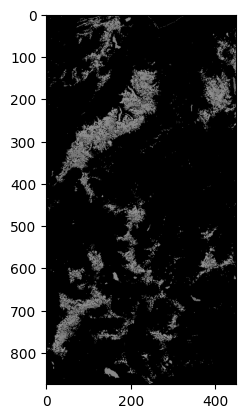

In [3]:
# Cropping to Where I want

def crop(mosaic):
    ilo = 3500                
    ihi = ilo + 3500          
    jlo = 3500                
    jhi = jlo + 1800          

    return mosaic[0, ilo:ihi, jlo:jhi]



Sb3_cropped = crop(Sb3_mosaic)
Sb5_cropped = crop(Sb5_mosaic)
sb6_cropped = crop(Sb6_mosaic)
Sb7_cropped = crop(Sb7_mosaic)

def ndwif(g,n):
    t =  (g-n)/(g+n + 1.0e-10)
    T  = 10
    return np.where(np.abs(t < T),t,np.sign(t)*T)

Sndwi = ndwif(Sb3_cropped, Sb5_cropped)

plt.imshow(Sndwi[::4,::4], cmap='Greys', vmin=-1, vmax=1)

In [15]:
Sb3_cropped.shape, Sb5_cropped.shape, Sndwi.shape

((3500, 1800), (3500, 1800), (3500, 1800))

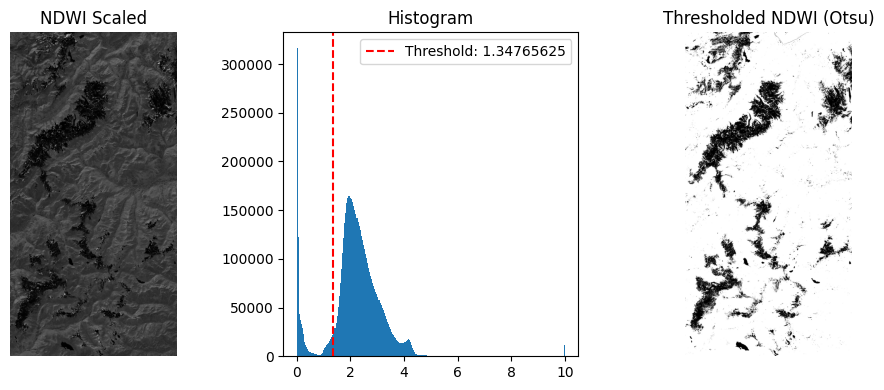

In [ ]:
#  Calculate Otsu threshold
thresh = threshold_otsu(Sndwi)

#  Apply threshold
binary = Sndwi > thresh

# Plot results
fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(Sndwi, cmap='gray')
ax[0].set_title('NDWI Scaled')
ax[0].axis('off')

ax[1].hist(Sndwi.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r', linestyle='--', label=f'Threshold: {thresh}')
ax[1].legend()

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('Thresholded NDWI (Otsu)')
ax[2].axis('off')

plt.tight_layout()
plt.show()

 # ANDSI

<Figure size 640x480 with 0 Axes>

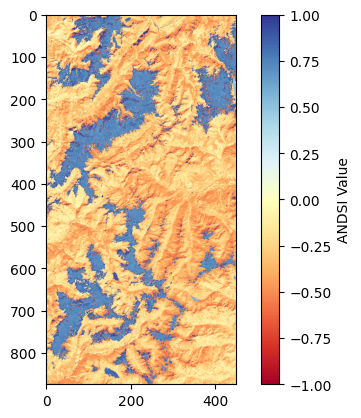

In [10]:
NDSI = (Sb3_cropped - Sb6_cropped) / (Sb3_cropped + Sb6_cropped + 1.0e-10)
CSI = Sb5_cropped / (Sb7_cropped + 1.0e-10)
ANDSI = (CSI - NDSI) / (CSI + NDSI + 1.0e-10)

plt.tight_layout()
plt.show()
plt.imshow(ANDSI[::4,::4], cmap="RdYlBu", vmin=-1, vmax=1)
plt.colorbar(label='ANDSI Value')

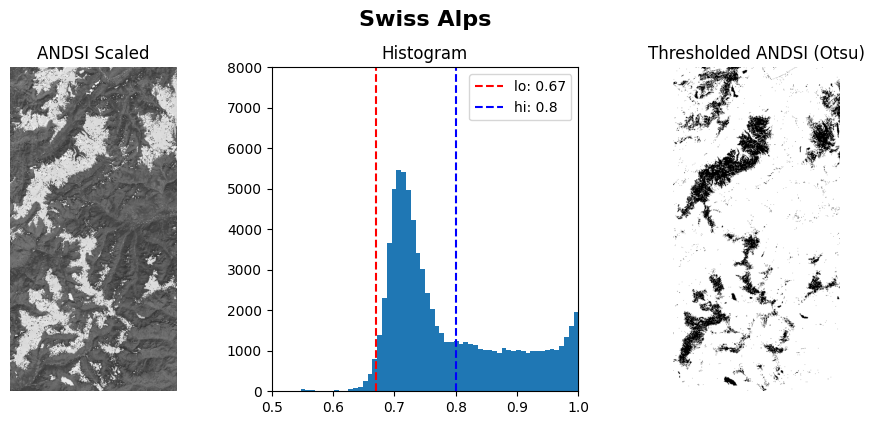

In [ ]:
# Manual Thresholding

lo = 0.67
hi = 0.8
# Apply threshold
binary2 = (ANDSI > lo) & (ANDSI < hi)
#binary = ANDSI > thresh


#  Plot results
fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(ANDSI[::4,::4], cmap='gray')
ax[0].set_title('ANDSI Scaled')
ax[0].axis('off')

ax[1].hist(ANDSI[::4,::4].ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(lo, color='r', linestyle='--', label=f'lo: {lo}')
ax[1].axvline(hi, color='b', linestyle='--', label=f'hi: {hi}')
ax[1].set_xlim(0.5,1.0)
ax[1].set_ylim(0,8000)
ax[1].legend()

ax[2].imshow(binary[::4,::4], cmap='gray')
ax[2].set_title('Thresholded ANDSI (Otsu)')
ax[2].axis('off')

plt.tight_layout()
fig.suptitle("Swiss Alps", fontsize=16, fontweight="bold", y=1.05)  # <-- add this
plt.show()

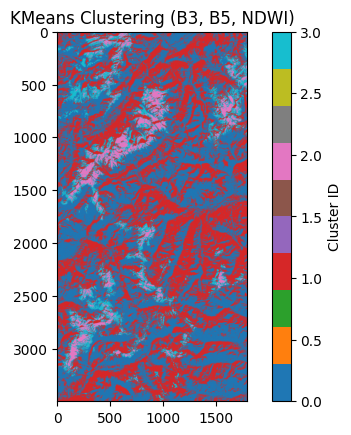

In [ ]:
# Kmeans
#  Stack bands as features
features = np.stack([Sb3_cropped, Sb5_cropped, Sndwi], axis=-1)  

# Flatten to 2D for clustering
rows, cols, bands = features.shape
X = features.reshape(-1, bands)

mask = ~np.any(np.isnan(X), axis=1) & ~np.all(X == 0, axis=1)
X_valid = X[mask]

#  Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
labels = np.full(X.shape[0], -1) 
labels[mask] = kmeans.fit_predict(X_valid)

# Reshape back to image
clustered = labels.reshape(rows, cols)

# 8. Visualise
plt.imshow(clustered, cmap='tab10')
plt.title("KMeans Clustering (B3, B5, NDWI)")
plt.colorbar(label='Cluster ID')
plt.show()

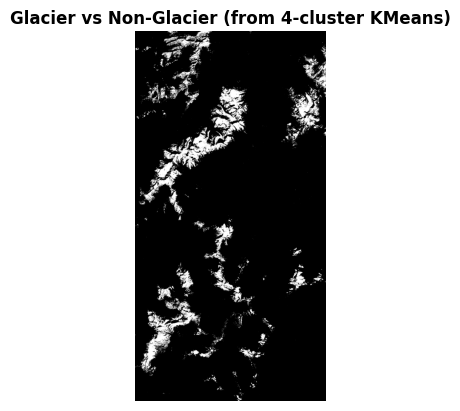

In [ ]:
glacier_cluster = 0   # Choosing cluster for mask
binary_map = np.zeros_like(clustered, dtype=np.uint8)
binary_map[clustered == glacier_cluster] = 1

plt.imshow(binary_map, cmap="gray")
plt.title("Glacier vs Non-Glacier (from 4-cluster KMeans)", fontweight="bold")
plt.axis("off")
plt.show()


# Metrics

In [ ]:
from rasterio.features import rasterize
inventory = gpd.read_file(r"C:\Users\ameli\Downloads\glims_download_11585\glims_polygons.shp")
# Using the shapeof mosaic
out_shape = Sb5_mosaic.shape[1:]  # e.g. (rows, cols)

# Rasterize glacier polygons into a mask matching B5 mosaic
gandolf_mask = rasterize(
    [(geom, 1) for geom in inventory.geometry],
    out_shape=out_shape,
    transform=Sb5_transform,  # ✅ use this!
    fill=0,
    dtype='uint8'
)

In [ ]:
with rasterio.open(
    "glacier_mask.tif",
    "w",
    driver="GTiff",
    height=glacier_mask.shape[0],
    width=glacier_mask.shape[1],
    count=1,
    dtype='uint8',
    crs=b3_srcs[0].crs,
    transform=Sb5_transform  
    dst.write(glacier_mask, 1)

In [ ]:
from rasterio.transform import Affine
# U
out_shape = binary_map.shape

# Compute cropped transform 
ilo, jlo = 3500, 3500
cropped_transform = Sb5_transform * Affine.translation(jlo, ilo)

# Reproject GANDOLF 
if inventory.crs != Sb3_srcs[0].crs:
    inventory = inventory.to_crs(Sb3_srcs[0].crs)

# Rasterize GANDOLF to match my area

gandolf_mask = rasterize(
    [(geom, 1) for geom in inventory.geometry],
    out_shape=out_shape,
    transform=cropped_transform,
    fill=0,
    dtype='uint8'
)

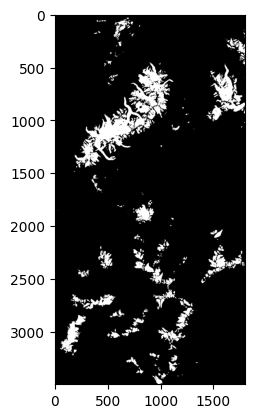

In [23]:
plt.imshow(gandolf_mask, cmap='gray')

In [ ]:
# Metrics
y_kmeans = binary_map.flatten()
y_true = gandolf_mask.flatten()

valid = (y_true >= 0)
y_pred_valid = y_kmeans[valid]
y_true_valid = y_true[valid]

cm = confusion_matrix(y_true_valid, y_pred_valid)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy  = (TP + TN) / cm.sum()
precision = TP / (TP + FP + 1e-10)
recall    = TP / (TP + FN + 1e-10)
f1        = 2 * (precision * recall) / (precision + recall + 1e-10)
iou       = TP / (TP + FP + FN + 1e-10)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")

Confusion Matrix:
 [[5499244  242767]
 [ 268441  289548]]
Accuracy:  0.919
Precision: 0.544
Recall:    0.519
F1 Score:  0.531
IoU:       0.362


# Random Forests

In [ ]:
# Stacking input features
X = np.stack([Sb3_cropped, Sb5_cropped, Sndwi], axis=-1).reshape(-1, 3)

# Flattening GANDOLF Mask
y = gandolf_mask.flatten()

# Removing no data
valid = (y >= 0)
X_valid = X[valid]
y_valid = y[valid]

In [ ]:
X_train, y_train = resample(X_valid, y_valid, n_samples=100_000, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


X_train, _, y_train, _ = train_test_split(
    X_valid, y_valid, 
    train_size=100_000, 
    stratify=y_valid,     
    random_state=42
)


In [ ]:
# Predict on full image
y_pred = clf.predict(X).reshape(Sb3_cropped.shape)


supervised_mask = y_pred

In [34]:
# Confusion Matrix
# Flatten both
y_true = gandolf_mask.flatten()
y_rf = supervised_mask.flatten()

# Filter valid pixels
valid = y_true >= 0
y_true_valid = y_true[valid]
y_pred_valid = y_rf[valid]

# Confusion Matrix & Report
cm = confusion_matrix(y_true_valid, y_pred_valid)
print("Confusion Matrix:\n", cm)

print(classification_report(y_true_valid, y_pred_valid, target_names=["Non-Glacier", "Glacier"]))


Confusion Matrix:
 [[5553822  188189]
 [ 246776  311213]]
              precision    recall  f1-score   support

 Non-Glacier       0.96      0.97      0.96   5742011
     Glacier       0.62      0.56      0.59    557989

    accuracy                           0.93   6300000
   macro avg       0.79      0.76      0.78   6300000
weighted avg       0.93      0.93      0.93   6300000



# Presentation

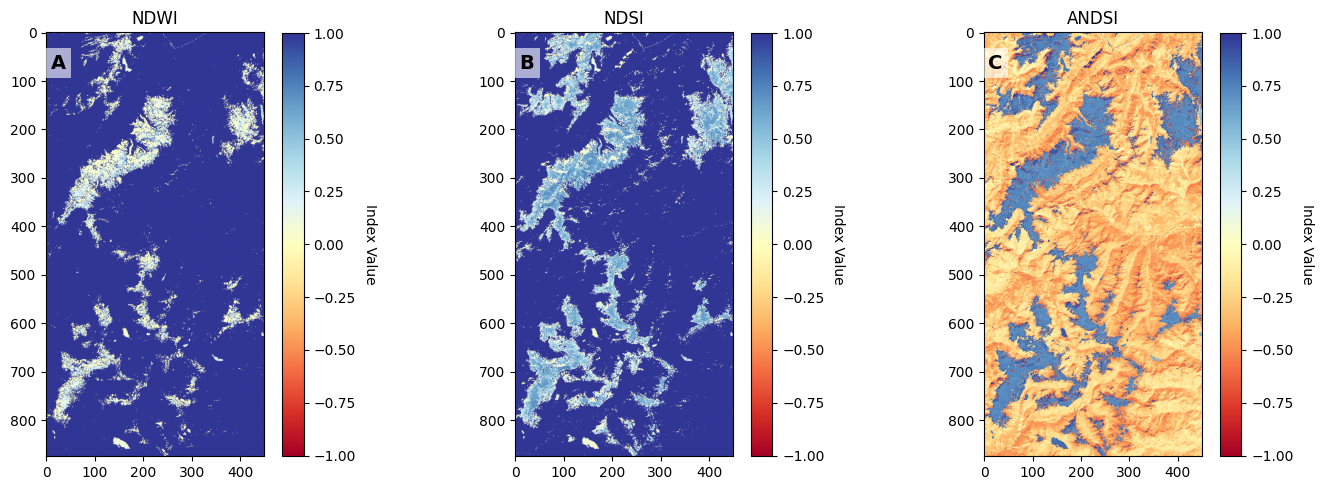

In [35]:
# Indicies comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# NDWI
im1 = axes[0].imshow(Sndwi[::4, ::4], cmap='RdYlBu', vmin=-1, vmax=1)
axes[0].set_title("NDWI")
cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label("Index Value", rotation=270, labelpad=15)

# NDSI
im2 = axes[1].imshow(NDSI[::4, ::4], cmap='RdYlBu', vmin=-1, vmax=1)
axes[1].set_title("NDSI")
cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label("Index Value", rotation=270, labelpad=15)

# ANDSI
im3 = axes[2].imshow(ANDSI[::4, ::4], cmap='RdYlBu', vmin=-1, vmax=1)
axes[2].set_title("ANDSI")
cbar3 = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
cbar3.set_label("Index Value", rotation=270, labelpad=15)

# Add panel labels A, B, C
labels = ["A", "B", "C"]
for ax, label in zip(axes, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=14, fontweight="bold", va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

plt.tight_layout()
plt.savefig("indices_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("indices_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()


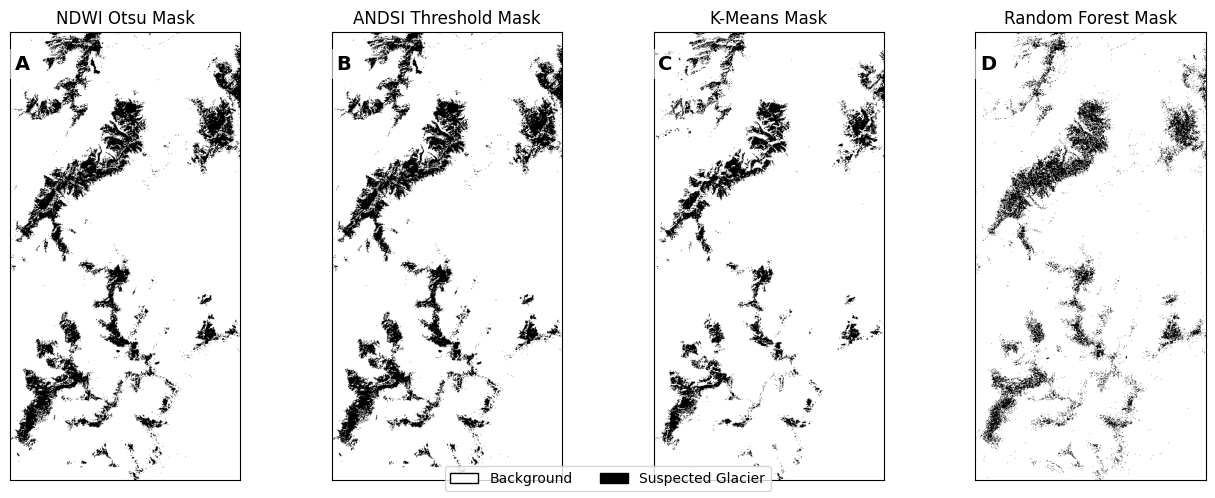

In [ ]:

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# --- Force consistency: 0 = glacier (black), 1 = background (white) ---
bin_ndsi = 1 - binary.astype(int)
bin_andsi  = 1 - binary2.astype(int)
bin_kmeans = 1 - binary_map.astype(int)
bin_rf     = 1 - supervised_mask.astype(int)

# NDWI Otsu
im4 = axes[0].imshow(bin_ndsi[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[0].set_title("NDWI Otsu Mask")

# ANDSI
im5 = axes[1].imshow(bin_andsi[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[1].set_title("ANDSI Threshold Mask")

# K-Means
im6 = axes[2].imshow(bin_kmeans[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[2].set_title("K-Means Mask")

# Random Forest
im7 = axes[3].imshow(bin_rf[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[3].set_title("Random Forest Mask")

# Add panel labels
labels = ["A", "B", "C", "D"]
for ax, label in zip(axes, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=14, fontweight="bold", va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
    ax.set_xticks([]); ax.set_yticks([])
    
# Shared legend with outlines
black_patch = mpatches.Patch(facecolor='black', edgecolor='black', label='Suspected Glacier')
white_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Background')

fig.legend(handles=[white_patch, black_patch],
           loc='lower center', ncol=2, frameon=True)

plt.tight_layout(rect=[0, 0.12, 1, 1])  

plt.tight_layout()
plt.savefig("Methods_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("Methods_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))


bin_andsi  = 1 - ANDSI_mask.astype(int)
bin_kmeans = 1 - glacier_mask.astype(int) # making them the same colour
bin_rf     = 1 - supervised_mask.astype(int)

# NDWI Otsu
im4 = axes[0].imshow(binary[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[0].set_title("NDWI Otsu Mask")

# ANDSI
im5 = axes[1].imshow(bin_andsi[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[1].set_title("ANDSI Threshold Mask")

# K-Means
im6 = axes[2].imshow(bin_kmeans[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[2].set_title("K-Means Mask")

# Random Forest
im7 = axes[3].imshow(bin_rf[::4, ::4], cmap='gray', vmin=0, vmax=1)
axes[3].set_title("Random Forest Mask")

# Add panel labels
labels = ["A", "B", "C", "D"]
for ax, label in zip(axes, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=14, fontweight="bold", va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
    ax.set_xticks([]); ax.set_yticks([])
    
# Shared legend with outlines
black_patch = mpatches.Patch(facecolor='black', edgecolor='black', label='Suspected Glacier')
white_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Background')

fig.legend(handles=[white_patch, black_patch],
           loc='lower center', ncol=2, frameon=True)

plt.tight_layout(rect=[0, 0.12, 1, 1])  

plt.tight_layout()
plt.savefig("Methods_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("Methods_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Confusion matrix 
# Andsi Thresholding
# 
y_true = gandolf_mask.flatten()
y_andsi = binary2.flatten()

# Filter valid pixels
valid = y_true >= 0
y_true_valid = y_true[valid]
y_pred_valid = y_andsi[valid]

# Confusion Matrix & Report
cm1 = confusion_matrix(y_true_valid, y_pred_valid)
print("Confusion Matrix:\n", cm1)

print(classification_report(y_true_valid, y_pred_valid, target_names=["Non-Glacier", "Glacier"]))

Confusion Matrix:
 [[5330828  411183]
 [ 175187  382802]]
              precision    recall  f1-score   support

 Non-Glacier       0.97      0.93      0.95   5742011
     Glacier       0.48      0.69      0.57    557989

    accuracy                           0.91   6300000
   macro avg       0.73      0.81      0.76   6300000
weighted avg       0.93      0.91      0.91   6300000



In [41]:
# NDWI
# Confusion Matrix
# Flatten both
y_true = gandolf_mask.flatten()
y_NDWI = binary.flatten()

# Filter valid pixels
valid = y_true >= 0
y_true_valid = y_true[valid]
y_pred_valid = y_NDWI[valid]

# Confusion Matrix & Report
cm = confusion_matrix(y_true_valid, y_pred_valid)
print("Confusion Matrix:\n", cm)

print(classification_report(y_true_valid, y_pred_valid, target_names=["Non-Glacier", "Glacier"]))

Confusion Matrix:
 [[5330828  411183]
 [ 175187  382802]]
              precision    recall  f1-score   support

 Non-Glacier       0.97      0.93      0.95   5742011
     Glacier       0.48      0.69      0.57    557989

    accuracy                           0.91   6300000
   macro avg       0.73      0.81      0.76   6300000
weighted avg       0.93      0.91      0.91   6300000



In [ ]:
# Easier function for confusion Matrix 
def confusion_metrics(y_true, y_pred):
    """
    Compute confusion matrix metrics for binary classification.
    Assumes: 1 = glacier, 0 = background
    """
    y_true = y_true.astype(np.uint8).ravel()
    y_pred = y_pred.astype(np.uint8).ravel()

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    eps = 1e-9
    acc  = (tp + tn) / (tp + tn + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)
    iou  = tp / (tp + fp + fn + eps)
    spec = tn / (tn + fp + eps)

    # Robust MCC
    denom = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if denom == 0:
        mcc = 0.0
    else:
        mcc = (tp*tn - fp*fn) / denom

    return {
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "IoU_glacier": iou,
        "Specificity": spec,
        "MCC": mcc
    }

In [44]:
import pandas as pd
results = {
    "NDWI Otsu": confusion_metrics(y_true, y_NDWI),
    "ANDSI":     confusion_metrics(y_true, y_andsi),
    "KMeans":    confusion_metrics(y_true, y_kmeans),
    "RandomForest": confusion_metrics(y_true, y_rf)
}

df = pd.DataFrame(results).T[
    ["Accuracy","Precision","Recall","F1","IoU_glacier","MCC"]
]

print(df.round(3))

C:\Users\ameli\AppData\Local\Temp\ipykernel_21548\1978144785.py:23: RuntimeWarning: overflow encountered in scalar multiply
  denom = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
C:\Users\ameli\AppData\Local\Temp\ipykernel_21548\1978144785.py:27: RuntimeWarning: overflow encountered in scalar multiply
  mcc = (tp*tn - fp*fn) / denom
C:\Users\ameli\AppData\Local\Temp\ipykernel_21548\1978144785.py:23: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


              Accuracy  Precision  Recall     F1  IoU_glacier        MCC
NDWI Otsu        0.907      0.482   0.686  0.566        0.395  64314.411
ANDSI            0.907      0.482   0.686  0.566        0.395  64314.411
KMeans           0.919      0.544   0.519  0.531        0.362        NaN
RandomForest     0.931      0.623   0.558  0.589        0.417        NaN


C:\Users\ameli\AppData\Local\Temp\ipykernel_21548\1978144785.py:27: RuntimeWarning: overflow encountered in scalar subtract
  mcc = (tp*tn - fp*fn) / denom


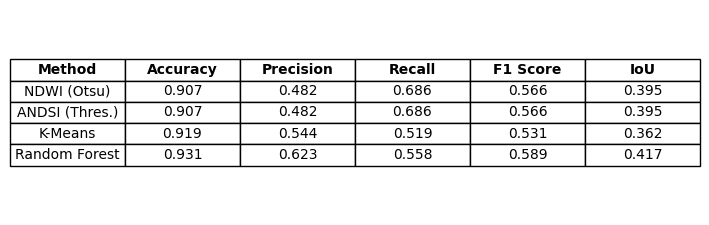

In [45]:
# Pick only key metrics
cols = ["Accuracy","Precision","Recall","F1","IoU_glacier"]

df = pd.DataFrame(results).T[cols].copy()
df = df.astype(float).round(3)
df = df.replace([np.inf, -np.inf], np.nan).fillna("—")

# Rename columns + methods
df = df.rename(columns={
    "F1": "F1 Score",
    "IoU_glacier": "IoU"
})
df = df.rename(index={
    "NDWI Otsu": "NDWI (Otsu)",
    "ANDSI": "ANDSI (Thres.)",
    "KMeans": "K-Means",
    "RandomForest": "Random Forest"
})

# Move index into a column
df.insert(0, "Method", df.index)
df.reset_index(drop=True, inplace=True)

# --- Plot the table ---
n_rows, n_cols = df.shape
fig, ax = plt.subplots(figsize=(1.2*n_cols, 0.5 + 0.5*n_rows))
ax.axis("off")

the_table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc="center",
    cellLoc="center"
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.2)

# Bold headers
for j in range(n_cols):
    the_table[(0, j)].set_text_props(weight="bold")

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.savefig("metrics_table_tibet.png", dpi=300, bbox_inches="tight")
plt.savefig("metrics_table_tibet.pdf", dpi=300, bbox_inches="tight")
plt.show()